In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_csv(r'C:\Users\Morgan Smith\Desktop\university\data mining\CW_ModelDevelopment_no_edit.csv')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
training_dataset, testing_dataset = train_test_split(dataset, test_size=0.20, random_state=42)

In [5]:
#training
train_independent_x = training_dataset.iloc[:, 2: -1]
train_dependent_y = training_dataset.iloc[:,-1]

#testing
test_independent_x = testing_dataset.iloc[:, 2: -1]
test_dependent_y = testing_dataset.iloc[:,-1]

In [6]:
from sklearn.preprocessing import LabelEncoder

#training
label_encoder = LabelEncoder()
binary_train_dependent_y = label_encoder.fit_transform(train_dependent_y)

#testing
label_encoder1 = LabelEncoder()
binary_test_dependent_y = label_encoder1.fit_transform(test_dependent_y)

In [7]:
b_y=pd.DataFrame(binary_train_dependent_y)
b_y.value_counts()

0    10427
1     1573
dtype: int64

In [8]:
from sklearn.impute import SimpleImputer
#training
train_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_imputer.fit(train_independent_x)
updated_train_independent_x = train_imputer.transform(train_independent_x)

#testing
test_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
test_imputer.fit(test_independent_x)
updated_test_independent_x = test_imputer.transform(test_independent_x)

# Using SMOTE to balance the data

In [17]:
from imblearn.combine import SMOTETomek
#training
st=SMOTETomek(0.50)
x_train_st, y_train_st = st.fit_resample(updated_train_independent_x, binary_train_dependent_y)

#testing
st1=SMOTETomek(0.50)
x_test_st1, y_test_st1 = st1.fit_resample(updated_test_independent_x, binary_test_dependent_y)

C:\Users\Morgan Smith\anaconda3\envs\gpu_nb\lib\site-packages\imblearn\utils\_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,
C:\Users\Morgan Smith\anaconda3\envs\gpu_nb\lib\site-packages\imblearn\utils\_validation.py:591: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning,


# Min-max scaler (normalization)

In [18]:
# best results were given by min-max

# from sklearn.preprocessing import MaxAbsScaler
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

# scaler = MaxAbsScaler()
# scaler = RobustScaler()
scaler = QuantileTransformer()
# scaler = Normalizer()
# scaler = MinMaxScaler()
# scaler = StandardScaler()

#trainging
scaler.fit(x_train_st)
scaled_train_independent_x = scaler.transform(x_train_st)

#testing
scaler.fit(x_test_st1)
scaled_test_independent_x = scaler.transform(x_test_st1)

In [19]:
#scaler.data_max_

In [20]:
# the scaler stores the standand diviation of the features in scale_
#scaler.scale_

In [21]:
from sklearn.decomposition import PCA

#training
pca = PCA(n_components=15)
pca.fit(scaled_train_independent_x)
pca_train_x = pca.transform(scaled_train_independent_x)

#testing
pca = PCA(n_components=15)
pca.fit(scaled_test_independent_x)
pca_test_x = pca.transform(scaled_test_independent_x)

# Finding the k value

In [22]:
# error = []
# for k in range(1,20):
#     knn_model = KNeighborsClassifier(n_neighbors=k)
#     y_pred = cross_val_predict(knn_model, pca_train_x, binary_train_dependent_y, cv=10) 
#     error.append(mean_squared_error(binary_train_dependent_y, y_pred))

In [23]:
# import matplotlib.pyplot as plt
# plt.plot(range(1,20), error)
# plt.xlabel('K values')
# plt.ylabel('Error')

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

In [25]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(pca_train_x, y_train_st)

KNeighborsClassifier(n_neighbors=3)

In [26]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [27]:
y_prediction = cross_val_predict(knn_model, pca_test_x, y_test_st1, cv=10)
#y_prediction = knn_model.predict(pca_test_x)
knn_accuracy = knn_model.score(pca_train_x, y_train_st)
error_rate = 1- knn_accuracy

# Predict probabilities

In [30]:
r_prob = [0 for _ in range(len(y_test_st1))]
knn_prob = knn_model.predict_proba(pca_test_x)

In [31]:
knn_prob = knn_prob[:,1]

# Computing AUROC and ROC curve values

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

In [33]:
r_auc = roc_auc_score(y_test_st1, r_prob)
knn_auc = roc_auc_score(y_test_st1, knn_prob)

In [34]:
print(r_auc)
print(knn_auc)

0.5
0.7440807634952709


# calculate ROC curve

In [35]:
r_fpr, r_tpr, _ = roc_curve(y_test_st1, r_prob)
knn_fpr, knn_tpr, _ = roc_curve(y_test_st1, knn_prob)

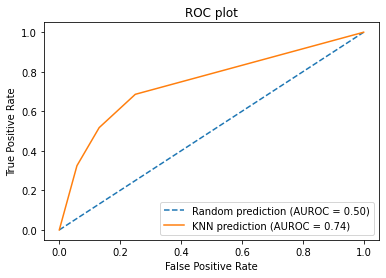

In [36]:
import matplotlib.pylab as plt
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.2F)' % r_auc)
plt.plot(knn_fpr, knn_tpr, linestyle='-', label='KNN prediction (AUROC = %0.2F)' % knn_auc)

plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [37]:
print('Error rate: ', error_rate)
print('\n')
print('f1 score for knn: ', f1_score(y_test_st1, y_prediction)) 
print('\n')
print('MCC: ', matthews_corrcoef(y_test_st1, y_prediction))
print('\n')
print('confusion matrix: \n', confusion_matrix(y_test_st1, y_prediction))

Error rate:  0.0354402393029003


f1 score for knn:  0.8805653710247349


MCC:  0.8207328247682134


confusion matrix: 
 [[2312  291]
 [  47 1246]]


In [38]:
print(classification_report(y_test_st1, y_prediction))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      2603
           1       0.81      0.96      0.88      1293

    accuracy                           0.91      3896
   macro avg       0.90      0.93      0.91      3896
weighted avg       0.92      0.91      0.91      3896

